# Zemmour versus Taha : traitement de l'information dans Twitter

Période du 8 au 15 mai 2022 (limité par l'API de Twitter)

In [132]:
import tweepy
import pandas as pd
import nltk
import re
from wordcloud import WordCloud

In [133]:
#
# Get Token for API v2 here : https://developer.twitter.com/
#
client = tweepy.Client(bearer_token='XXXX')

In [134]:
# Define study time range, sadly by defaut we only have access to the 7 last days of data 😟
start_time = '2022-05-09T00:00:00Z'
end_time = '2022-05-15T00:00:00Z'

In [135]:
# Get Tweets about people
# From https://tweeterid.com/
TB_ID = '835174698623336448'
EZ_ID = '1183418538285027329'

#
# Here : Switch from TB_ID to EZ_ID and vice versa
#
tweets = tweepy.Paginator(client.get_users_mentions,
    id = EZ_ID,
    tweet_fields=['text'],
    max_results= 100
).flatten(1000)

tb_tweets = []
for tweet in tweets:
    tb_tweets.append(tweet.text)

tweets = pd.DataFrame(tb_tweets, columns=['content'])

total_mentions = tweets.size
tweets

,content
0,@Socrate90001 @ZemmourEric Alors l’industrie a...
1,Il est content @ZemmourEric que certains suive...
2,@maglio_nicolas @CENDRINEPENNELL @salome_benya...
3,@UnMonsieurBlanc @VismaviedAed @giroudannemari...
4,@BFMTV @Clem_Autain 🔴🔴Autant Mme @Clem_Autain ...
...,...
843,@giroudannemarie @OuvryDiane @ZemmourEric Calm...
844,@OuvryDiane @ZemmourEric J’ai de plus en plus ...
845,@MissNath84 @OuvryDiane @ZemmourEric C'est jolie
846,@urbany73 @ZemmourEric Je vous le souhaite de ...


In [136]:
tweets.describe()

,content
count,848
unique,848
top,@Socrate90001 @ZemmourEric Alors l’industrie a...
freq,1


In [137]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\micka\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data preparation

In [138]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words=stopwords.words('french')
stemmer=PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [139]:
import re
cleaned_data=[]

def clean_tweet(tweet):
   # Delete mentions
   tweet_content = re.sub(r'@[A-Za-z0-9_]+', '', tweet.content)
   # Delete links
   tweet_content = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', tweet_content)
   # remove hashtags
   tweet_content = re.sub(r'#[A-Z0-9]+', '', tweet_content)
   # all lower
   tweet_content = tweet_content.lower().split()
   # stemming + remove stop words
   cleaned_tweet = [word for word in tweet_content if (word not in stop_words)]
   tweet.content = ' '.join(cleaned_tweet)
   
   return tweet

tweets.apply(clean_tweet, axis=1)

tweets

,content
0,alors l’industrie a reculé aussi allemagne. po...
1,content certains suivent délire complotiste ? ...
2,va gagner. 7 % 4 mois si mal....g peur offre g...
3,🤡
4,🔴🔴autant mme interrogée cellule mafia ds cas 📌...
...,...
843,calme anne-marie. poses téléphone. profite bea...
844,j’ai plus plus d’affection z 😘🥳😬
845,c'est jolie
846,souhaite tout cœur..🇲🇫🌿


## Bag of words analysis

In [140]:
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

sentiments_analysis = []
for i in tweets.content:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        sentiments_analysis.append('Positive')
    elif (vs < 0):
        sentiments_analysis.append('Negative')
    else:
        sentiments_analysis.append('Neutral')

tweets['sentiment'] = sentiments_analysis
tweets

,content,sentiment
0,alors l’industrie a reculé aussi allemagne. po...,Negative
1,content certains suivent délire complotiste ? ...,Positive
2,va gagner. 7 % 4 mois si mal....g peur offre g...,Positive
3,🤡,Neutral
4,🔴🔴autant mme interrogée cellule mafia ds cas 📌...,Positive
...,...,...
843,calme anne-marie. poses téléphone. profite bea...,Positive
844,j’ai plus plus d’affection z 😘🥳😬,Positive
845,c'est jolie,Positive
846,souhaite tout cœur..🇲🇫🌿,Positive


In [141]:
import plotly.express as px

title = 'Analyse du sentiment des mentions ('+ str(total_mentions) + ' tweets)'
fig = px.pie(tweets, names='sentiment', title=title)

fig.show()

## Word Cloud

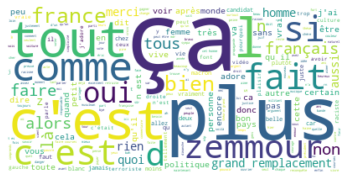

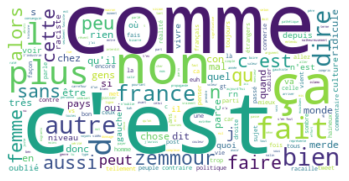

In [142]:
import matplotlib.pyplot as plt

def create_wordcloud(text):
    wc = WordCloud(background_color = "white", max_words = 500, repeat = True)
    wc.generate(str(text))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
#word cloud for positive sentiments
create_wordcloud(tweets[tweets.sentiment == 'Positive']['content'].values)

#wordcloud for negative sentimenst
create_wordcloud(tweets[tweets.sentiment == 'Negative']['content'].values)